In [1]:
import os 
import numpy as np
from numpy.linalg import eig
import mne
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from itertools import combinations

from scipy.stats import ttest_ind, f_oneway
from scipy import signal
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.ensemble import EasyEnsembleClassifier
import smote_variants
from xgboost import XGBRFClassifier

from mne.decoding import CSP

In [2]:
def getList(dict):
    list = []
    for key in dict.keys():
        list.append(key)
    return list

In [3]:
inners = ['BACK2','DOWN2','FORWARD2','LEFT2','RIGHT2','UP2']

In [4]:
#подгрузка эпох. Лучше грузить без прелоуда, чтобы не грузить оперативку
#loading epoch without preload to avoid extra ram usage
mainPath = r'/home/dataFolder/DataPrior/Spanish/epo'
epoData = []
loadR = [1,10]
for i in range(loadR[0],loadR[1]):
    epoData.append(mne.read_epochs(mainPath + '/' + 'sub-{}'.format(i) + '/' + 'sub-{}-epo.fif'.format(i), preload = False, verbose = 0))

In [5]:
#we need to load raw data to do that. Loading all subjects data at the same time needs a lot of RAM, which is not appropriate according to working in server i.e. jupyterhub.
#should try the theory on one subject.
mainPath = r'/home/dataFolder/DataPrior/Spanish/raw'
rawData = []
anats = []
loadR = [1,10]
for i in range(loadR[0],loadR[1]):
    rawData.append(mne.io.read_raw(mainPath + '/' + 'sub-{}'.format(i) + '/' + 'sub-{}.edf'.format(i), preload = False, verbose = 0))
    anats.append(mne.events_from_annotations(rawData[i - loadR[0]]))

Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIGHT2', 'UP1', 'UP2']
Used Annotations descriptions: ['Annotation', 'BACK1', 'BACK2', 'DOWN1', 'DOWN2', 'FORWARD1', 'FORWARD2', 'GO', 'GZ', 'LEFT1', 'LEFT2', 'RIGHT1', 'RIG

In [6]:
#crop the recodring by the real borders of each word trials
crops = {}
fixed = {}
for ind, sub in enumerate(rawData):
    cur = {}
    fix = {}
    for word in inners:
        alls = anats[ind][0][np.where(anats[ind][0][:,2] == anats[ind][1][word])[0], 0]
        #start and end of full segment
        start, end = np.array([alls[0]]) , np.array([alls[-1]])
        #starts and ends of subsegments (if there are gaps of longer than 6 sec)
        med_st = alls[np.where((np.diff(alls) // 500) >= 6)]
        med_en = alls[np.where((np.diff(alls) // 500) >= 6)[0] + 1]
        #all in one
        united = np.sort(np.concatenate([start,med_st, med_en, end]))
        united  = united.reshape(united.shape[0] // 2, 2)
        #iterate over segment indicies
        cr = []
        fi = []
        for st_en in united:
            seg = sub.copy().crop(tmin = st_en[0] // 500, tmax = st_en[1] // 500)
            if len(seg) // 500 > 15:
                fi.append(mne.make_fixed_length_epochs(seg, duration = 5.0, overlap = 1.5, verbose = 0))
                cr.append(seg)
        #collect by word and subject
        cur[word] = cr
        fix[word] = fi
    crops[ind] = cur
    fixed[ind] = fix

In [7]:
#what's next? Calculating coherence in every fixed epoch i.e. doing it with overlapping in word pronunciation period. What is the problem? The problem is coherence calculating in 
#pair of channels, 703 pairs. It's shitty in context of visualization.

In [25]:
np.save('/home/dataFolder/DataPrior/Spanish/coh/coherence_late_1.npy', allCoh)

In [8]:
#load coherencies if there is a file
allCoh = np.load('/home/dataFolder/DataPrior/Spanish/coh/coherence_late.npy',allow_pickle='TRUE').item()

In [7]:
allCoh = {}
for sub in fixed.keys():
    print('Calculating coherence for subject {}'.format(sub))
    labCoh = {}
    for word in fixed[sub].keys():
        print('Word {}'.format(word))
        uniq_ch_ind = list(combinations(range(len(epoData[sub].ch_names)), 2))
        crops = fixed[sub][word]
        cropCoh = []
        for crop in crops:
            data = crop.get_data()
            epoCoh = []
            for epoch in data:
                pairCoh = []
                for pair in uniq_ch_ind:
                    f, Cxy = signal.coherence(epoch[pair[0],:], epoch[pair[1],:], fs = 500, nperseg = 500)
                    Cxy = np.array([Cxy[np.where(f<70)[0]]])
                    pairCoh.append(Cxy)
                pairCoh = np.expand_dims(np.concatenate(pairCoh, axis = 0), axis = 0)
                epoCoh.append(pairCoh)
            epoCoh = np.concatenate(epoCoh, axis = 0)
            cropCoh.append(epoCoh)
        labCoh[word] = cropCoh
    allCoh[sub] = labCoh

Calculating coherence for subject 0
Word BACK2
Loading data for 15 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 17 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 18 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 20 events and 2500 original time points ...
0 bad epochs dropped
Word DOWN2
Loading data for 21 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 19 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 17 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 19 events and 2500 original time points ...
0 bad epochs dropped
Word FORWARD2
Loading data for 19 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 17 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 19 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 21 events

In [ ]:
#we forgot about rest reference state due to our labeling structure... Let's crop resting state from initial GO label + 40 seconds (the recording are not all pure for longer segment)

In [38]:
goCrop = {}
fixedGo = {}
for ind, sub in enumerate(rawData):
    gocur = {}
    start = anats[ind][0][np.where(anats[ind][0][:,2] == anats[ind][1]['GO'])[0][0], 0] // 500
    end = start + 40
    goCrop[ind] = sub.copy().crop(tmin = start, tmax = end)
    fixedGo[ind] = mne.make_fixed_length_epochs(goCrop[ind], duration = 5.0, overlap = 1.5, verbose = 0)

In [39]:
#calc coherence
goCoh = {}
for sub in fixed.keys():
    print('Calculating rest coherence for subject {}'.format(sub))
    uniq_ch_ind = list(combinations(range(len(epoData[sub].ch_names)), 2))
    data = fixedGo[sub].get_data()
    epoCoh = []
    for epoch in data:
        pairCoh = []
        for pair in uniq_ch_ind:
            f, Cxy = signal.coherence(epoch[pair[0],:], epoch[pair[1],:], fs = 500, nperseg = 500)
            Cxy = np.array([Cxy[np.where(f<70)[0]]])
            pairCoh.append(Cxy)
        pairCoh = np.expand_dims(np.concatenate(pairCoh, axis = 0), axis = 0)
        epoCoh.append(pairCoh)
    epoCoh = np.concatenate(epoCoh, axis = 0)
    goCoh[sub] = epoCoh

Calculating rest coherence for subject 0
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 1
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 2
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 3
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 4
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 5
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 6
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest coherence for subject 7
Loading data for 11 events and 2500 original time points ...
0 bad epochs dropped
Calculating rest

In [40]:
#some feature selection with oneway anova

In [41]:
statBand = (60,65)
pThres = 0.001
pis = []
for sub in allCoh.keys():
    goSt = np.mean(goCoh[sub][:,:,statBand[0]:statBand[1]], axis = 2)
    wordSt = np.zeros((1,703,70))
    for word in inners:
        curW = np.concatenate(allCoh[sub][word], axis = 0)
        wordSt = np.append(wordSt, curW, axis = 0)
    wordSt = np.mean(wordSt[1:,:,statBand[0]:statBand[1]], axis = 2)
    t, p = f_oneway(wordSt, goSt, axis = 0)
    pis.append(np.array([p]))
pis = np.concatenate(pis, axis = 0)
#get indices of p value lower than threshold
inds = np.where(pis < pThres)
#redefine pis as array of zeros
pis = np.zeros((pis.shape))
#equals one the significant pairs
pis[inds] = 1

In [42]:
print('Percent of channels with significant difference for ...')
for ind, sub in enumerate(pis):
    percent = np.argwhere(sub == 1).shape[0]/ sub.shape[0]
    print('sub-{}'.format(ind),round(percent * 100,2),'%')

Percent of channels with significant difference for ...
sub-0 1.71 %
sub-1 5.55 %
sub-2 4.13 %
sub-3 11.38 %
sub-4 28.88 %
sub-5 41.11 %
sub-6 30.87 %
sub-7 14.65 %
sub-8 31.44 %


<Axes: >

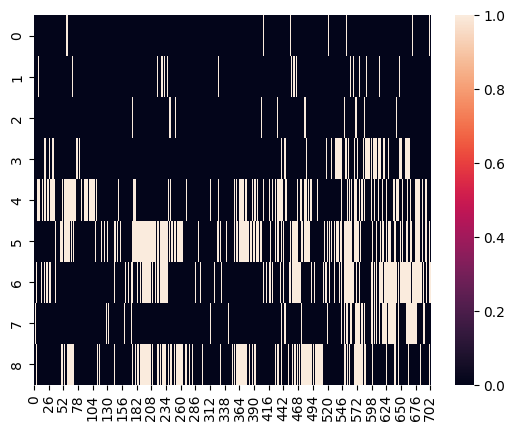

In [43]:
sns.heatmap(pis)

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
#Supress default INFO logging

import logging
logger = logging.getLogger('smote_variants')
logger.disabled = True

In [70]:
#classification trials
accuracies = []
overSamp = True
for sub in allCoh.keys():
    
    clf = Pipeline([
        #('scaler', StandardScaler()),
        ('svm', SVC(kernel = 'rbf', gamma = 'scale'))
    ])
    
    ch_ind = np.where(pis[sub,:] == 1)[0]
    X_go = np.mean(goCoh[sub][:,ch_ind,60:65], axis = 2)
    y_go = np.ones((X_go.shape[0]))

    X_word = np.zeros((1,703,70))
    for word in inners:
        curW = np.concatenate(allCoh[sub][word], axis = 0)
        X_word = np.append(X_word, curW, axis = 0)
        
    X_word = np.mean(X_word[1:,ch_ind,60:65], axis = 2)
    y_word = np.zeros((X_word.shape[0]))

    X = np.concatenate([X_go, X_word], axis = 0)
    y = np.concatenate([y_go, y_word])

    if overSamp == True:
        over_sampler = smote_variants.Supervised_SMOTE()
        #over_sampler = smote_variants.polynom_fit_SMOTE_bus()
        X, y = over_sampler.sample(X, y)

    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.33)

    scores = cross_val_score(clf, X, y, scoring = 'f1')
    print(scores)
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    accuracies.append(accuracy_score(test_y, y_pred))

[0.99408284 1.         1.         0.98823529 0.99408284]
[0.98181818 0.98809524 0.99393939 0.98795181 0.9704142 ]
[1.         0.98850575 1.         1.         0.95454545]
[0.98795181 1.         1.         1.         1.        ]
[1.         1.         1.         1.         0.98113208]
[1.         0.98780488 1.         1.         1.        ]
[1. 1. 1. 1. 1.]
[1.         1.         1.         0.96774194 1.        ]
[1. 1. 1. 1. 1.]


In [32]:
np.array([np.abs((np.mean(X_word, axis = 0) - np.mean(X_go, axis = 0)))]).T * 100

array([[34.09943883],
       [14.80707028],
       [11.02336381],
       [ 7.93000478],
       [ 5.27608385],
       [ 6.44609282],
       [ 6.44614904],
       [ 4.64146786],
       [ 5.33065814],
       [ 8.91438175],
       [ 5.56180412],
       [ 6.32918297],
       [16.42669541],
       [13.89935236],
       [ 5.25821358],
       [10.86988512],
       [19.10094715],
       [ 4.97093565],
       [12.07902256],
       [18.86580257],
       [ 7.37575097],
       [15.01778401],
       [18.52327355],
       [12.374925  ],
       [12.84702   ],
       [10.57437663],
       [12.89817264],
       [12.83668289],
       [15.47833513],
       [11.85844678],
       [ 8.04975919],
       [ 9.03369068],
       [ 9.96909541],
       [11.92859037],
       [ 6.27929515],
       [ 5.434746  ],
       [ 9.07046986],
       [ 5.12838803],
       [ 7.62015899],
       [ 4.66195376],
       [ 6.1186219 ],
       [ 5.11242497],
       [ 5.07360184],
       [ 6.98834816],
       [ 5.15347696],
       [ 5

In [48]:
X_word.shape

(332, 221)

In [47]:
X_go.shape

(11, 221)